# The task
We need to build a model to determine the cost of cars.

Important for the customer:

- the quality of the prediction;
- prediction speed;
- studying time.

# 1. Start

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lightgbm
import catboost as catboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('/datasets/autos.csv')
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b>  The data was load. There are 16 columns in the dataset, some have gaps. We contact the specialists responsible for uploading data. If the provided data is the best option, handle the gaps.  </div>

In [4]:
#the PostalCode column is of type int64,
# change it to str, because I think this is more of a categorical feature ("address" of the car)
data['PostalCode']=data['PostalCode'].astype(str)

In [5]:
#consider the RegistrationYear column and make it a categorical feature
data['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [6]:
data = data.drop(data[data['RegistrationYear'] < 1850].index)
data = data.drop(data[data['RegistrationYear'] > 2020].index)
data['RegistrationYear']=data['RegistrationYear'].astype(str)
data['RegistrationYear'].unique()

array(['1993', '2011', '2004', '2001', '2008', '1995', '1980', '2014',
       '1998', '2005', '1910', '2016', '2007', '2009', '2002', '2018',
       '1997', '1990', '2017', '1981', '2003', '1994', '1991', '1984',
       '2006', '1999', '2012', '2010', '2000', '1992', '2013', '1996',
       '1985', '1989', '2015', '1982', '1976', '1983', '1973', '1969',
       '1971', '1987', '1986', '1988', '1970', '1965', '1945', '1925',
       '1974', '1979', '1955', '1978', '1972', '1968', '1977', '1961',
       '1960', '1966', '1975', '1963', '1964', '1954', '1958', '1967',
       '1959', '1956', '1941', '1962', '1929', '1957', '1940', '1949',
       '2019', '1937', '1951', '1953', '1933', '1950', '1948', '1952',
       '1932', '1942', '1935', '1936', '1923', '1930', '1944', '1943',
       '1934', '1938', '1928', '1919', '1931', '1915', '1920', '1947',
       '1927', '1946'], dtype=object)

In [7]:
#make sure all columns are of the correct data type
print(data.dtypes)

DateCrawled          object
Price                 int64
VehicleType          object
RegistrationYear     object
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
DateCreated          object
NumberOfPictures      int64
PostalCode           object
LastSeen             object
dtype: object


In [8]:
#check for passes
data.isnull().sum()

DateCrawled              0
Price                    0
VehicleType          37319
RegistrationYear         0
Gearbox              19695
Power                    0
Model                19630
Kilometer                0
RegistrationMonth        0
FuelType             32767
Brand                    0
NotRepaired          71007
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
#check for duplicates
data.duplicated().sum()

4

In [10]:
#remove full duplicates
data=data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [11]:
#since we are working with categorical features, we will replace the blanks with "None",
# this will be a separate category for the model
data=data.fillna('None')
data.isnull().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [12]:
#remove columns that can not affect the price of the car
data=data.drop(['DateCrawled', 'LastSeen', 'DateCreated', 'NumberOfPictures', 'RegistrationMonth'], axis=1)
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,PostalCode
0,480,None,1993,manual,0,golf,150000,petrol,volkswagen,None,70435
1,18300,coupe,2011,manual,190,None,125000,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,None,90480
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no,60437
...,...,...,...,...,...,...,...,...,...,...,...
354189,0,None,2005,manual,0,colt,150000,petrol,mitsubishi,yes,2694
354190,2200,None,2005,None,0,None,20000,None,sonstige_autos,None,39576
354191,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no,26135
354192,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no,87439


In [13]:
#analyze quantitative features
data=data.copy()
digit = ['Power','Kilometer','Price']
data[digit].describe()

,Power,Kilometer,Price
count,354194.000000,354194.000000,354194.00000
mean,110.077720,128267.799567,4417.67439
std,189.537689,37823.278992,4514.09886
min,0.000000,5000.000000,0.00000
25%,69.000000,125000.000000,1050.00000
50%,105.000000,150000.000000,2700.00000
75%,143.000000,150000.000000,6400.00000
max,20000.000000,150000.000000,20000.00000


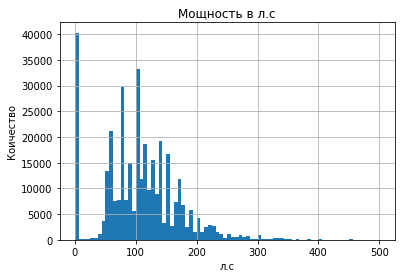

In [14]:
data['Power'].hist(bins=80, range=(0,500))
plt.ylabel('quantity')
plt.xlabel('h.p')
plt.title('Power in h.p');

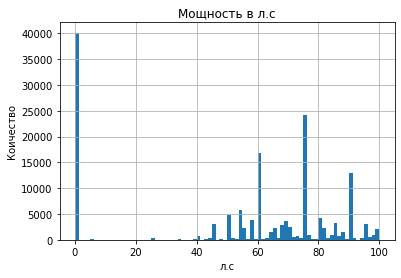

In [15]:
#we will limit the range to 100 to consider carefully
data['Power'].hist(bins=80, range=(0,100))
plt.ylabel('quantity')
plt.xlabel('h.p')
plt.title('Power in hp');

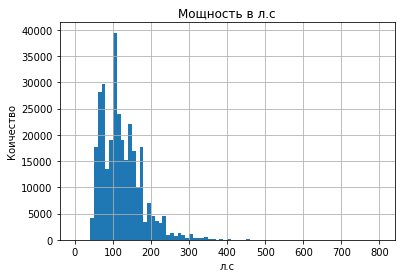

In [16]:
data['Power']=data['Power'].where((data['Power'] > 40) & (data['Power'] < 500))
data['Power'].hist(bins=80, range=(0,800))
plt.ylabel('quantity')
plt.xlabel('h.p')
plt.title('Power in hp');

In [17]:
#remove values that do not fall within the range we have selected
data = data.drop(data[(data['Power'] < 40) & (data['Power'] >500)].index)

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> Column Power has been limited to more realistic values</div>

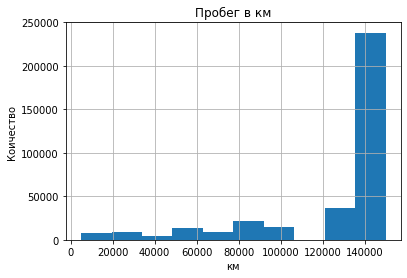

In [18]:
data['Kilometer'].hist()
plt.ylabel('quantity')
plt.xlabel('km')
plt.title('Mileage in km');

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> 
The Kilometer column appears to have no anomalies. Because the mileage can be anything other than zero.</div>

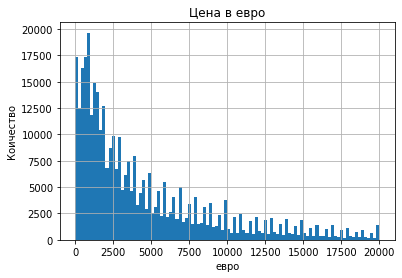

In [19]:
data['Price'].hist(bins=100)
plt.ylabel('quantity')
plt.xlabel('EUR')
plt.title('Price in EUR');

In [20]:
data=data.copy()
data = data.drop(data[data['Price'] < 10].index)
data['Price'].isnull().sum()

0

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> 
Zeros removed in the Price column</div>

In [21]:
#removed nan in quantitative columns
data[digit].dropna(inplace=True)

In [22]:
# select the target feature and features
# split the dataset into train, valid, test in a ratio of 3: 1: 1
# perform scaling of features
target=data['Price']
features=data.drop('Price', axis=1)

features_train, features_couple, target_train, target_couple = train_test_split(
    features, target, test_size=0.4, random_state = 90, shuffle = True)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_couple,target_couple, test_size =0.5, random_state = 90, shuffle = True)

numeric = ['Power','Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

print('train shape:', features_train.shape,target_train.shape)
print('valid_shape:', features_valid.shape,target_valid.shape)
print('test_shape:', features_test.shape, target_test.shape)

train shape: (205323, 10) (205323,)
valid_shape: (68441, 10) (68441,)
test_shape: (68442, 10) (68442,)


In [23]:
print(features_train[numeric].head(5))

           Power  Kilometer
317108 -0.293328   0.577378
57071  -1.258513  -1.827096
279206  1.069285  -1.559932
81063  -0.577206   0.577378
93875  -1.258513   0.577378


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> 
4 full duplicates were identified in the dataset - deleted, replaced the gaps with str "None", deleted columns that did not affect the target feature, scaled the features, divided the dataset into 3 samples</div>

# 2. Model

In [24]:
#a function that will return training time, prediction time and metric on a test sample
def model_time_test(model, X_train, y_train,  X_valid, y_valid, X_test, y_test, cat_features = None):
    
    begin = time.time()
    
    if cat_features:
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
    else:
        model.fit(X_train, y_train, verbose=False)
        

    train_time = time.time() - begin
    
    begin = time.time()  
    predictions = model.predict(X_valid)
    predictions_time = time.time() - begin
    
    predictions_test=model.predict(X_test)
    test_result=(mean_squared_error(y_test,predictions_test))**0.5

    return train_time, predictions_time, test_result

### model LinearRegression 

Unfortunately, the kernel crashes when the feature categorization is performed using the ohe method, and LinearRegression does not quite work correctly with OE. So I moved those cells and commented out. Locally, everything works for me. Since I was convinced that this model does not satisfy the task at hand, I allowed myself this trick.

In [25]:
#we will carry out the coding of categorical features
#data_ohe = pd.get_dummies(data, drop_first = True)
#data=data_ohe
#data.head(5)

In [26]:
# Commented out this cell, if you wish, you can uncomment it and make sure that it works
# the answer is also commented out below

#%%time

#model_linear=LinearRegression(normalize=True)
#model_linear.fit(features_train, target_train)
#predictions_valid = model_linear.predict(features_valid)
#result_linear=(mean_squared_error(target_valid, predictions_valid))**0.5

#print('RMSE:', result_linear)  

#RMSE: 4050.0203216247112
#CPU times: user 2min 38s, sys: 0 ns, total: 2min 38s
#Wall time: 2min 49s

### train the CatBoostRegressor model and select the best hyperparameters

In [27]:
cv = KFold(n_splits=3, shuffle=True, random_state=90)

cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'NotRepaired', 'PostalCode', 'RegistrationYear' ] 

model_catboost = CatBoostRegressor(random_state=90, loss_function='RMSE', silent=True, cat_features=cat_col)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_model_catboost = GridSearchCV(model_catboost,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [28]:
#%%time
#grid_model_catboost.fit(features_train, target_train)

In [29]:
#grid_model_catboost.best_params_

In [30]:
%%time

cat_col = ['VehicleType', 'Gearbox', 'Model', 'FuelType',
           'Brand', 'NotRepaired', 'PostalCode', 'RegistrationYear' ] 

model=CatBoostRegressor(
    random_state=90, loss_function='RMSE', iterations = 60, depth=10, learning_rate=0.1778279410038923)

model.fit(features_train, target_train, cat_features=cat_col, verbose = False)
predictions_valid=model.predict(features_valid)
result_catboost = mean_squared_error(target_valid,predictions_valid) ** 0.5
print('RMSE:',result_catboost)

RMSE: 1723.2931713254145
CPU times: user 31 s, sys: 2.36 s, total: 33.4 s
Wall time: 34.1 s


In [31]:
train_time_boost, predictions_time_boost, test_result_boost = model_time_test(
    model,features_train,target_train,features_valid, target_valid, features_test, target_test, cat_col)

print(train_time_boost, predictions_time_boost, test_result_boost)

33.80181550979614 0.29099178314208984 1698.8219376497195


### train the LGBMRegressor model and select the best hyperparameters

In [32]:
#we will carry out the coding of categorical features
encoder=OrdinalEncoder()
data_ordinal=pd.DataFrame(encoder.fit_transform(data[cat_col]), columns = cat_col)
print(data_ordinal.head(5))

   VehicleType  Gearbox  Model  FuelType  Brand  NotRepaired  PostalCode  \
0          0.0      2.0  117.0       7.0   38.0          0.0      4665.0   
1          3.0      2.0   26.0       3.0    1.0          2.0      4343.0   
2          7.0      1.0  118.0       3.0   14.0          0.0      6895.0   
3          6.0      2.0  117.0       7.0   38.0          1.0      6935.0   
4          6.0      2.0  102.0       3.0   31.0          1.0      3855.0   

   RegistrationYear  
0              68.0  
1              86.0  
2              79.0  
3              76.0  
4              83.0  


In [33]:
#merge tables - quantitative and categorical signs, remove nan
data_join=data[['Price','Power', 'Kilometer']].join(data_ordinal, how='right')
data_join.dropna(inplace=True)

In [34]:
target=data_join['Price']
features=data_join.drop('Price', axis=1)

features_train, features_couple, target_train, target_couple = train_test_split(
    features, target, test_size=0.4, random_state = 90, shuffle = True)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_couple,target_couple, test_size =0.5, random_state = 90, shuffle = True)


In [35]:
numeric = ['Power','Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric]=scaler.transform(features_train[numeric])
features_valid[numeric]=scaler.transform(features_valid[numeric])
features_test[numeric]=scaler.transform(features_test[numeric])

In [36]:
model_lgb = LGBMRegressor(boosting_type='gbdt', verbose=0, random_state=90)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'n_estimators': [40, 60],
    'num_leaves': [21, 31, 41],
    'iterations': [40, 60]
}

grid_model_lgb = GridSearchCV(model_lgb,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [38]:
%%time
grid_model_lgb.fit(features_train, target_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed:  9.0min finished


CPU times: user 8min 54s, sys: 2.25 s, total: 8min 56s
Wall time: 9min 3s


GridSearchCV(cv=KFold(n_splits=3, random_state=90, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=No...
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0, verbose=0),
             iid='warn', n_jobs=None,
             param_grid={'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.005623

In [39]:
grid_model_lgb.best_params_

{'iterations': 40,
 'learning_rate': 0.1778279410038923,
 'n_estimators': 40,
 'num_leaves': 41}

In [40]:
%%time

model_lgb = LGBMRegressor(
    n_estimators=40, num_leaves=41, num_iterations=40, learning_rate=0.1778279410038923, random_state=90)
model_lgb.fit(features_train, target_train, verbose=False)
predictions_valid = model_lgb.predict(features_valid)
result_lgb = mean_squared_error(target_valid,predictions_valid) ** 0.5
print('RMSE:',result_lgb)

RMSE: 2950.893388187381
CPU times: user 3.6 s, sys: 24 ms, total: 3.63 s
Wall time: 3.67 s


In [41]:
#combine the train and valid samples and compare the metrics before and after
merge_features = pd.concat([features_train, features_valid])
merge_target = pd.concat([target_train, target_valid])

In [42]:
%%time

model_lgb = LGBMRegressor(
    n_estimators=40, num_leaves=41, num_iterations=40, learning_rate=0.1778279410038923, random_state=90)
model_lgb.fit(merge_features, merge_target, verbose=False)
predictions_valid = model_lgb.predict(features_valid)
result_lgb = mean_squared_error(target_valid,predictions_valid) ** 0.5
print('RMSE:',result_lgb)

RMSE: 2925.7610889329103
CPU times: user 4.54 s, sys: 41.6 ms, total: 4.58 s
Wall time: 4.67 s


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> Metrics after merging are not much better, but better</div>

### train the DecisionTreeRegressor model and manually select the best hyperparameters

In [43]:
%%time

model_tree=DecisionTreeRegressor(random_state=90, max_depth=6)
model_tree.fit(merge_features, merge_target)
predictions_valid=model_tree.predict(features_valid)
result_tree=(mean_squared_error(target_valid, predictions_valid))**0.5

print('RMSE:', result_tree)  

RMSE: 3057.7704458448766
CPU times: user 543 ms, sys: 0 ns, total: 543 ms
Wall time: 577 ms


### train the RandomForestRegressor model and select the best hyperparameters

In [44]:
%%time

best_result=10000
best_depth=0
best_est = 0
for est in range(10,60,10):
    for depth in range (1,6):
        model_forest=RandomForestRegressor(random_state=90, n_estimators = est, max_depth = depth)
        model_forest.fit(features_train, target_train)
        predictions_valid=model_forest.predict(features_valid)
        result_forest=(mean_squared_error(target_valid, predictions_valid))**0.5
        if result_forest<best_result:
            best_result=result_forest
            best_depth=depth
            best_est=est
            
print('RMSE:', result_forest, best_depth, best_est)  

RMSE: 3102.5820471823467 5 40
CPU times: user 1min 40s, sys: 0 ns, total: 1min 40s
Wall time: 1min 41s


In [57]:
model_forest=RandomForestRegressor(random_state=90, n_estimators = 40, max_depth = 5)
model_forest.fit(merge_features, merge_target)
predictions_valid=model_forest.predict(features_valid)
result_forest=(mean_squared_error(target_valid, predictions_valid))**0.5
print(result_forest)

3103.965396936793


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> Trained 5 different models. For each, we selected hyperparameters and evaluated the quality using the rmse metric. Visualized training and prediction times. We decided on the most suitable models and tested them on a test sample </div>

# 3. Analysis

In [46]:
#a function that will return training time, prediction time and metric on a test sample
def model_time_test(model, X_train, y_train,  X_valid, y_valid, X_test, y_test, cat_features = None):
    
    begin = time.time()
    
    if cat_features:
        model.fit(X_train, y_train, cat_features=cat_features, verbose=False)
    else:
        model.fit(X_train, y_train, verbose=False)
        

    train_time = time.time() - begin
    
    begin = time.time()  
    predictions = model.predict(X_valid)
    predictions_time = time.time() - begin
    
    predictions_test=model.predict(X_test)
    test_result=(mean_squared_error(y_test,predictions_test))**0.5

    return train_time, predictions_time, test_result

In [47]:
#a function that will return training time, prediction time and metric on a test set of other models

def simple_model_time_test(model, X_train, y_train,  X_valid, y_valid, X_test, y_test):
    
    start = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start
    
    start = time.time()  
    predictions = model.predict(X_valid)
    predict_time = time.time() - start
    
    predict_test=model.predict(X_test)
    test_rmse=(mean_squared_error(y_test,predict_test))**0.5
    
    return fit_time, predict_time, test_rmse   

In [48]:
train_time_lgb, predictions_time_lgb, test_result_lgb = model_time_test(
    model_lgb,features_train,target_train,features_valid, target_valid, features_test, target_test)

print(train_time_lgb, predictions_time_lgb, test_result_lgb)

3.043647289276123 0.2952001094818115 2931.0907067805506


In [49]:
train_time_tree, predictions_time_tree, test_result_tree= simple_model_time_test(
    model_tree,features_train,target_train,features_valid, target_valid,features_test, target_test)

print(train_time_tree, predictions_time_tree, test_result_tree)    

0.3917245864868164 0.005960226058959961 3050.251953010179


In [50]:
train_time_forest, predictions_time_forest, test_result_forest= simple_model_time_test(
    model_forest,features_train,target_train, features_valid, target_valid, features_test, target_test)

print(train_time_forest, predictions_time_forest, test_result_forest)  

11.102547883987427 0.1378030776977539 3094.1130849682245


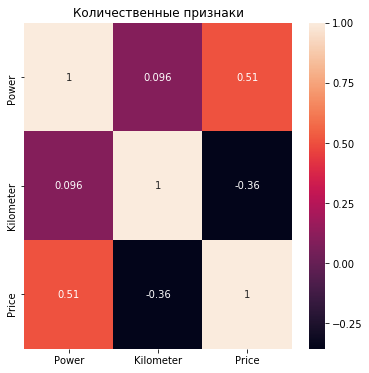

In [51]:
import seaborn as sns
def heatmap_digit(data, title):
    cols = ['Power', 'Kilometer', 'Price']
    plt.figure(figsize=(6, 6))
    hm = sns.heatmap(data[cols].corr(), cbar=True, annot=True)
    plt.title(title)
    plt.show();
    
heatmap_digit(data=data, title='Quantitative features')    

<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>Conclusion:</b> The graph shows that the more powerful the car, the more expensive it is and the inverse relationship between km and price. The more mileage the car has, the lower the price </div>

In [52]:
#we will summarize the results of the models in one table
results = [
    [train_time_boost, predictions_time_boost, result_catboost, test_result_boost],
    [train_time_lgb, predictions_time_lgb, result_lgb, test_result_lgb],
    [train_time_tree, predictions_time_tree, result_tree, test_result_tree],
    [train_time_forest, predictions_time_forest, result_forest, test_result_forest]
];
pd.DataFrame(data = results,
             index=['CatBoost', 'LightGBM', 'TreeRegressor', 'ForestRegressor'],
             columns=['trainig_time', 'predict_time', 'rmse', 'test_rmse'])

,trainig_time,predict_time,rmse,test_rmse
CatBoost,33.801816,0.290992,1723.293171,1698.821938
LightGBM,3.043647,0.295200,2925.761089,2931.090707
TreeRegressor,0.391725,0.005960,3057.770446,3050.251953
ForestRegressor,11.102548,0.137803,3104.342159,3094.113085


In [53]:
#let's see how the importance of values ​​is distributed according to features in the best model
feature_importances = model.get_feature_importance()
feature_names = cat_col

feature_importances_grid = pd.DataFrame([], columns = ['feature', 'importance'])
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    feature_importances_grid.append([name, score])
    feature_importances_grid = feature_importances_grid.append({'feature': name, 'importance': score}, ignore_index=True)   

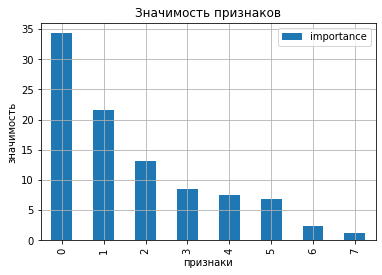

In [58]:
feature_importances_grid.plot(kind='bar', grid = True)
plt.xlabel('features') 
plt.ylabel('importance')
plt.title('Features importance');

In [55]:
feature_importances_grid

,feature,importance
0,Gearbox,34.299991
1,FuelType,21.614725
2,RegistrationYear,13.094563
3,NotRepaired,8.548276
4,VehicleType,7.480504
5,Brand,6.815015
6,PostalCode,2.332406
7,Model,1.291045


<div class="alert alert-info" style="border:solid blue 2px; padding: 20px"> <b>General conclusion:</b> In the course of all the work, we analyzed 5 different models, in the end we decided on the best one - CatBoost. In terms of the quality of the metric, it wins all other models. The learning speed is, of course, the fastest, but 33 seconds is quite acceptable. The highest degree of importance for the feature is the gearbox and the least importance belongs to the column - model</div>